<a href="https://colab.research.google.com/github/parmarsuraj99/numereval/blob/master/examples/evaluating_numereval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Numereval

In [ ]:
!pip install numerapi
!pip install numereval

## Loading Libraries

In [2]:
import os
import re
import gc
import csv
import glob
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import numerapi

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
napi = numerapi.NumerAPI(verbosity="info")
napi.download_current_dataset(unzip=True)

latest_round = napi.get_current_round()
current_ds = os.path.join('numerai_dataset_'+str(latest_round),'')

./numerai_dataset_249.zip: 389MB [00:05, 70.7MB/s]                           
2021-02-06 13:08:02,558 INFO numerapi.base_api: unzipping file...


In [4]:
TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

# Submissions are scored by spearman correlation
def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]


# convenience method for scoring
def score(df):
    return correlation(df[PREDICTION_NAME], df[TARGET_NAME])


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)


# Read the csv file into a pandas Dataframe as float16 to save space
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))

    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)

    return df


In [5]:
%%time
print("Loading data...")

training_data = read_csv(f"{current_ds}/numerai_training_data.csv")
tournament_data = read_csv(f"{current_ds}/numerai_tournament_data.csv")
example_preds = read_csv(f"{current_ds}/example_predictions.csv")
validation_data = tournament_data[tournament_data.data_type == "validation"]

feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
print(f"Loaded {len(feature_names)} features")

Loading data...
Loaded 310 features
CPU times: user 50.2 s, sys: 2.78 s, total: 53 s
Wall time: 57.3 s


## predictions

In [6]:
print("Generating predictions...")
training_data[PREDICTION_NAME] = np.random.random((len(training_data)))
tournament_data[PREDICTION_NAME] = np.random.random((len(tournament_data)))

Generating predictions...


In [7]:
from numereval import numereval

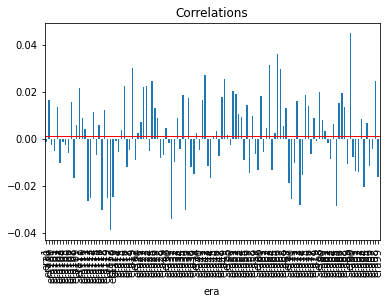

,metrics
mean,0.0012
std,0.0162
sharpe,0.0730
max_drawdown,-0.1513
max_feature_exp,0.0451
feature_exposure,0.0013


In [9]:
numereval.evaluate(training_data, plot=True, feature_exposure=True)

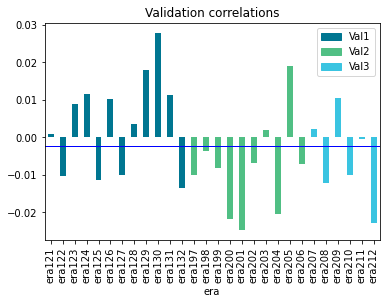

,metrics
mean,-0.0025
std_dev,0.0133
sharpe,-0.1855
feat_neutral_mean,-0.0023
max_drawdown,-0.1299
max_feature_exp,0.0398
feature_exposure_mean,0.0027
mmc_mean,-0.0020
corr_plus_mmc_sharpe,-0.1895
corr_example_preds,-0.0009


In [12]:
validation_data = tournament_data[tournament_data.data_type=="validation"]
numereval.diagnostics(validation_data, 
                      plot=True, 
                      example_preds_loc=
                      f"/content/numerai_dataset_{latest_round}/example_predictions.csv")

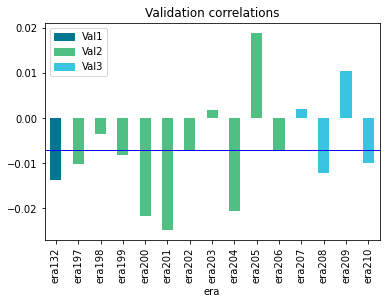

,metrics
mean,-0.0070
std_dev,0.0114
sharpe,-0.6152
feat_neutral_mean,-0.0080
max_drawdown,-0.0894
max_feature_exp,0.0391
feature_exposure_mean,0.0036
mmc_mean,-0.0055
corr_plus_mmc_sharpe,-0.6220
corr_example_preds,-0.0029


In [13]:
validation_data = tournament_data[tournament_data.data_type == "validation"]

#Specific eras in validation set
eras = validation_data.era.unique()[11:-2]

numereval.diagnostics(
    validation_data,
    plot=True,
    example_preds_loc=
    f"/content/numerai_dataset_{latest_round}/example_predictions.csv",
    eras=eras,
)

---

Future work: 

1. MMC metrics for training data (which will allow highly customizable train-validation splits)
2. metrics for Signals